# ARIMAモデルで予測

In [1]:
import sys
from pathlib import Path

import japanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmdarima as pm
from pmdarima import arima, utils, model_selection
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

sys.path.append('../')
from src.dataset import get_forecast_df
from src.constants import (
    target_column_list,
    Columns,
    scores_file_name,
    submission_file_name
)
from src.forecast_util import mape, LogConverter, get_result_base_dict

plt.style.use('ggplot')

In [2]:
# データロード
train_df, submit_df, ans_df = get_forecast_df('../data/')
print('train.csv...')
display(train_df.head(1))
print('submit.csv...')
display(submit_df.head(1))
print('ans.csv...')
display(ans_df.head(1))

train.csv...


,日,TensorFlow: (日本),PyTorch: (日本),Keras: (日本),Caffe: (日本),Deeplearning4j: (日本)
0,2016-01-01,0,0,0,0,0


submit.csv...


,日,TensorFlow: (日本),PyTorch: (日本),Keras: (日本),Caffe: (日本),Deeplearning4j: (日本)
0,2022-11-13,NaN,NaN,NaN,NaN,NaN


ans.csv...


,日,TensorFlow: (日本),PyTorch: (日本),Keras: (日本),Caffe: (日本),Deeplearning4j: (日本)
0,2022-11-13,22,0,0,0,0


In [3]:
# 学習用データを対数変換してカラムに追加しておく
converter = LogConverter()
for target_column in target_column_list:
    train_df[f'log_{target_column}'] = train_df[target_column].apply(converter.to_log)

## 予測ベースライン


過去1年分の平均値をそのまま予測値としてみる

In [6]:
result = get_result_base_dict()
mean_days = 365
for i, target_column in enumerate(target_column_list):
    target_df = train_df[target_column].iloc[-mean_days:]
    y_pred = np.array([target_df.mean()] * len(ans_df))
    result[i]['mape'] = mape(ans_df[target_column].values, y_pred)
    result[i]['rmse'] = np.sqrt(mean_squared_error(ans_df[target_column].values, y_pred))
    result[i]['mae'] = mean_absolute_error(ans_df[target_column].values, y_pred)
pd.DataFrame(result).to_csv('../result/arima/baseline_scores.csv', index=False)

## ARIMAモデル

In [5]:
# 階差次数の検討
kaisa_coeff_df = [
    {
        'framework': target_column,
        'd': 0,
        'D': 0
    }
    for target_column in target_column_list
]
for i, target_column in enumerate(target_column_list):
    kaisa_coeff_df[i]['d'] = arima.ndiffs(train_df[target_column])
    kaisa_coeff_df[i]['D'] = arima.nsdiffs(train_df[target_column], m=12)
kaisa_coeff_df = pd.DataFrame(kaisa_coeff_df)
kaisa_coeff_df

,framework,d,D
0,TensorFlow: (日本),1,0
1,PyTorch: (日本),1,0
2,Keras: (日本),0,0
3,Caffe: (日本),0,0
4,Deeplearning4j: (日本),1,0


TensorFlow: (日本) start...
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=4.93 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=6704.432, Time=0.13 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=6016.074, Time=0.39 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=2.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=6702.432, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=6014.818, Time=0.11 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=6016.005, Time=0.40 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=6015.460, Time=1.48 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=5736.175, Time=0.14 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=5737.388, Time=0.51 sec
 ARIMA(2,1,0)(0,0,1)[12] intercept   : AIC=5737.307, Time=0.43 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=5735.878, Time=1.63 sec
 ARIMA(2,1,0)(2,0,1)[12] intercept   : AIC=5734.785, Time=4.13 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=5733.949, Time=1.70 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=6013.602, Time=1.29 sec
 ARIM

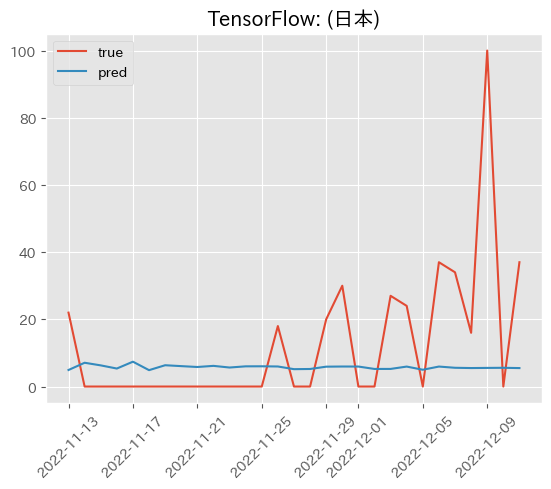

PyTorch: (日本) start...
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=5.33 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=6400.964, Time=0.23 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=5670.541, Time=0.31 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=3.96 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=6398.964, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=5668.684, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=5670.537, Time=0.48 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=5672.403, Time=1.07 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=5403.101, Time=0.14 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=5405.091, Time=0.56 sec
 ARIMA(2,1,0)(0,0,1)[12] intercept   : AIC=5405.091, Time=0.54 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=5407.087, Time=0.73 sec
 ARIMA(3,1,0)(0,0,0)[12] intercept   : AIC=5244.373, Time=0.18 sec
 ARIMA(3,1,0)(1,0,0)[12] intercept   : AIC=5246.355, Time=0.62 sec
 ARIMA(3,1,0)(0,0,1)[12] intercept   : AIC=5246.355, Time=0.64 sec
 ARIM

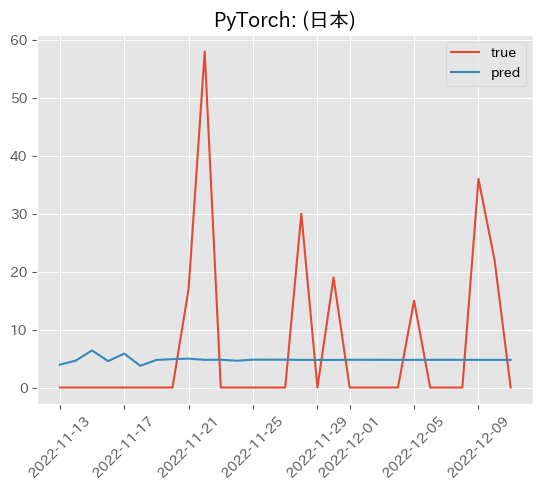

Keras: (日本) start...
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=5.34 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=4629.964, Time=0.13 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=4633.736, Time=0.50 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=4633.743, Time=0.55 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=5252.266, Time=0.05 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=4631.962, Time=0.30 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=4631.961, Time=0.34 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=1.48 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=4631.737, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=4631.744, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=4633.661, Time=0.72 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 9.642 seconds


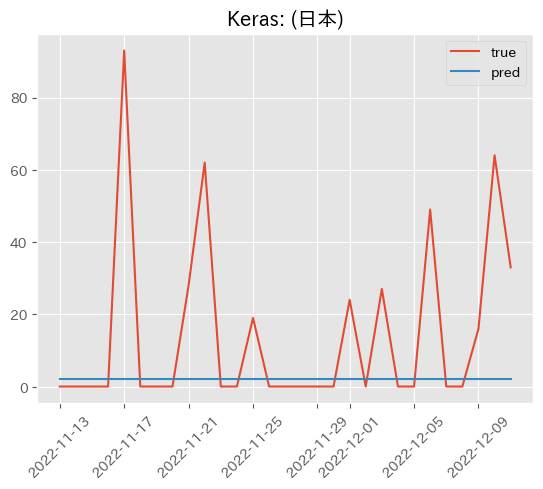

Caffe: (日本) start...
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=6.29 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=4352.850, Time=0.14 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=4354.622, Time=0.61 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=4354.626, Time=0.63 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=4893.578, Time=0.05 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=4354.006, Time=0.30 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=4354.005, Time=0.37 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=1.75 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=4353.559, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=4353.565, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=4355.564, Time=0.17 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 10.529 seconds


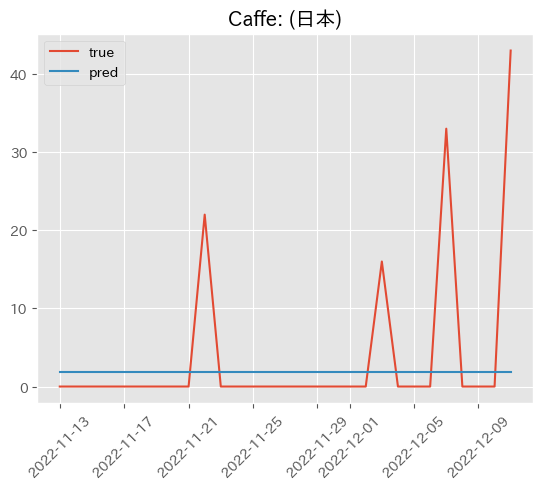

Deeplearning4j: (日本) start...
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=4.69 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=5930.154, Time=0.13 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=5254.715, Time=0.37 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=2.74 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=5928.154, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=5252.764, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=5254.714, Time=0.40 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=5256.714, Time=0.51 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=4945.954, Time=0.16 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=4947.901, Time=0.55 sec
 ARIMA(2,1,0)(0,0,1)[12] intercept   : AIC=4947.900, Time=0.57 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=4949.903, Time=0.83 sec
 ARIMA(3,1,0)(0,0,0)[12] intercept   : AIC=4782.127, Time=0.25 sec
 ARIMA(3,1,0)(1,0,0)[12] intercept   : AIC=4784.116, Time=0.61 sec
 ARIMA(3,1,0)(0,0,1)[12] intercept   : AIC=4784.116, Time=0.66 sec
 ARIM

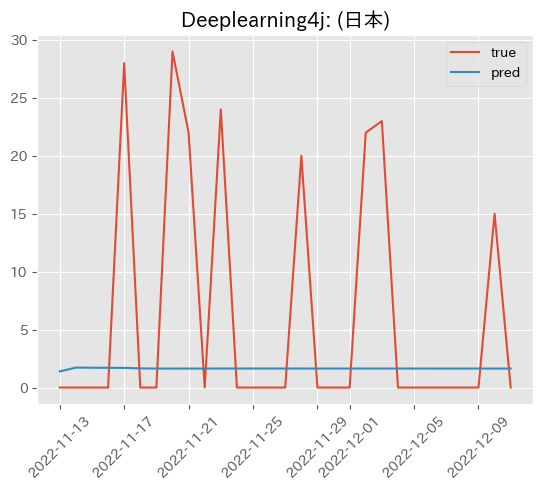

,framework,rmse,mape,mae
0,TensorFlow: (日本),22.308102,3.629528e+09,14.076968
1,PyTorch: (日本),14.026092,3.646583e+09,9.279258
2,Keras: (日本),27.015585,1.380004e+09,14.964031
3,Caffe: (日本),10.743535,1.654158e+09,5.320528
4,Deeplearning4j: (日本),11.444182,1.186663e+09,7.042902


In [8]:
dst_dir = Path('../result/arima/')
dst_dir.mkdir(exist_ok=True, parents=True)
result = get_result_base_dict()

for i, target_column in enumerate(target_column_list):
    print(f'{target_column} start...')
    # モデル作成
    d = kaisa_coeff_df[kaisa_coeff_df['framework'] == target_column]['d'].iloc[0]
    D = kaisa_coeff_df[kaisa_coeff_df['framework'] == target_column]['D'].iloc[0]
    arima_df = train_df.set_index(Columns.date)
    arima_model = pm.auto_arima(arima_df[f'log_{target_column}'], seasonal=True, m=12, trace=True, n_jobs=-1, d=d, D=D)
    # 予測
    pred = arima_model.predict(n_periods=len(ans_df)).apply(converter.to_base)
    # 予測結果と実際の結果をプロット
    plt.plot(ans_df.set_index(Columns.date)[target_column], label='true')
    plt.plot(pred, label='pred')
    plt.xticks(rotation=45)
    plt.legend()
    plt.title(target_column)
    plt.savefig(dst_dir / f'{target_column}_forecast.png')
    plt.show()

    # 評価指標計算
    result[i]['mae'] = mean_absolute_error(ans_df[target_column].values, pred.values)
    result[i]['rmse'] = np.sqrt(mean_squared_error(ans_df[target_column].values, pred.values))
    result[i]['mape'] = mape(ans_df[target_column].values, pred.values)
    # 結果データフレームの更新
    submit_df[target_column] = pred.values
result = pd.DataFrame(result)
display(result)
result.to_csv(dst_dir / scores_file_name, index=False)
submit_df.to_csv(dst_dir / submission_file_name, index=False)